In [9]:
import pandas as pd

train_df = pd.read_csv('../data/train_fp.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('../data/test_fp.csv', index_col='Unnamed: 0')
print("Train DF shape: {}".format(train_df.shape),
      "Test DF shape: {}".format(test_df.shape))


Train DF shape: (514, 4097) Test DF shape: (128, 4097)


In [10]:
X_train = train_df.iloc[:,:-1]
y_train = train_df.label.values

X_test = test_df.iloc[:,:-1]
y_test = test_df.label.values

In [12]:
import shap
import matplotlib.pyplot as plt

def create_shap(explainer_values, X_train, n_features = 10):
    # Create plots
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        explainer_values, 
        X_train,
        plot_type="bar",
        max_display=n_features,
        show=False
    )
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()

    # Detailed plot with distributions
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        explainer_values, 
        X_train,
        max_display=n_features,
        show=False
    )
    plt.title("SHAP Values Distribution")
    plt.tight_layout()
    plt.show()


In [13]:
from sklearn.ensemble import RandomForestRegressor

# best parameters obtained from Optimization with Ax platform
best_parameters = {'n_estimators': 100,
 'max_depth': 192,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.001}

rf_model = RandomForestRegressor(random_state=42, **best_parameters)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=192, max_features='sqrt',
                      min_samples_leaf=0.001, random_state=42)

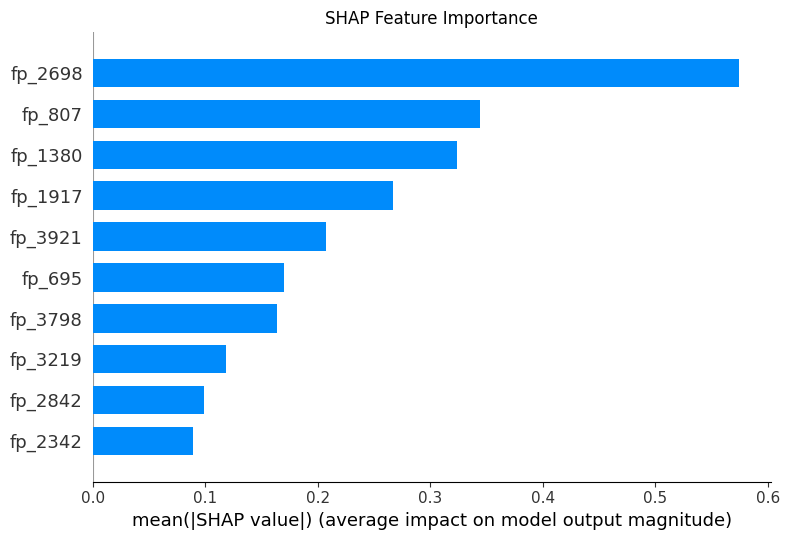

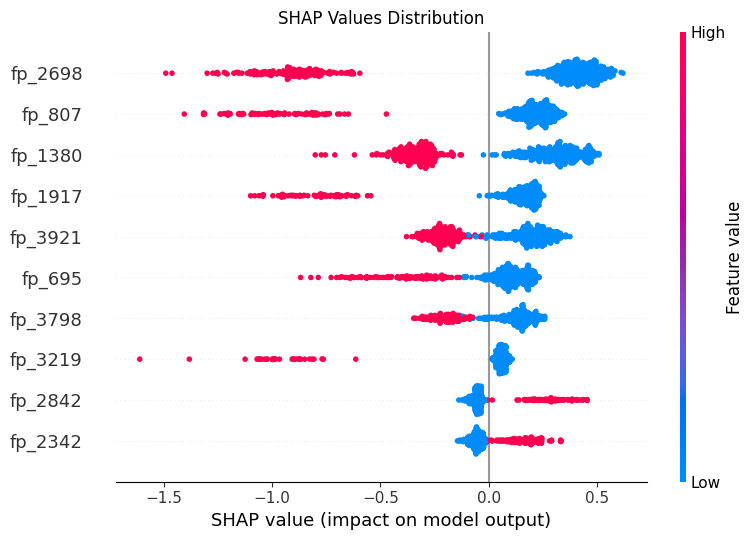

In [14]:
# Create explainer
rfr_explainer = shap.TreeExplainer(rf_model,
                                   data=X_train,
                                   feature_perturbation='interventional')

# Calculate SHAP values
rfr_explainer_values = rfr_explainer.shap_values(X_train)


create_shap(rfr_explainer_values, X_train, 10)


# Save SHAP values for later use
shap_df = pd.DataFrame(
    rfr_explainer_values,
    columns=X_train.columns
)

## Check fps

In [16]:
from rdkit import Chem
from rdkit.Chem import AllChem

def get_morganfp_df(data,
                    smiles_col='smiles',
                    label_col='label',
                    radius = 2,
                    ) -> pd.DataFrame:
    """
    Funtion to calculate MorganFPs and return them as DF
    """
    # Use SMILES as index in df
    data_temp = data.set_index(smiles_col)

    # Temp dictionary to store data
    temp_dict = {}
    
    # List of SMILES fialed to convert to MOL
    failed_smiles = []

    # Set up fingerptint generator
    fpgen = AllChem.GetMorganGenerator(radius=radius,
                                       fpSize=4096)

    for smile in data_temp.index:
        temp_mol = Chem.MolFromSmiles(smile)
        if temp_mol:
            # Set up additional output to store bit info
            ao = AllChem.AdditionalOutput()
            ao.CollectBitInfoMap()
            fps = fpgen.GetFingerprint(temp_mol, additionalOutput=ao)
        else:
            failed_smiles.append(smile)
        
        temp_dict[smile] = {'morganfp':fps,
                            'bitinfo': ao.GetBitInfoMap(),
                            'mol': temp_mol,
                            'label': data_temp.loc[smile, label_col]}
    
    morganfp_df = pd.DataFrame.from_dict(temp_dict, orient='index')

    if len(failed_smiles) > 0:
        print(f'Warning: {len(failed_smiles)} SMILES failed to convert to mol')
    
    return morganfp_df


data_train = train_df[["label"]].copy()
data_train['smiles'] = data_train.index.values
data_train.head()

morganfp_train = get_morganfp_df(data_train)
morganfp_train.head()


,morganfp,bitinfo,mol,label
CN(C)C(=O)c1ccc(cc1)OC,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{322: ((8, 1),), 695: ((11, 0),), 841: ((12, 1...",<rdkit.Chem.rdchem.Mol object at 0x7f9a70f28c10>,-9.625
CC(C)C=C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{66: ((1, 2),), 1366: ((4, 0),), 2049: ((1, 0)...",<rdkit.Chem.rdchem.Mol object at 0x7f9a70f28cf0>,2.452
CCc1cnccn1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{378: ((4, 0), (7, 0)), 690: ((2, 2),), 724: (...",<rdkit.Chem.rdchem.Mol object at 0x7f9a70f29000>,-5.809
CCCCCCCO,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{541: ((5, 2),), 807: ((7, 0),), 1130: ((6, 2)...",<rdkit.Chem.rdchem.Mol object at 0x7f9a70f290e0>,-2.917
Cc1cc(cc(c1)O)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{807: ((7, 0),), 875: ((2, 1), (4, 1), (6, 1))...",<rdkit.Chem.rdchem.Mol object at 0x7f9a70f291c0>,-5.444


In [17]:
import numpy as np

# Get top 10 features
shap_values = rfr_explainer_values
feature_importance = np.abs(shap_values).mean(0)
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})
top_10_features = feature_importance_df.sort_values('importance', ascending=False).head(10)
top_10_features_list = list(top_10_features.index)

In [18]:
top_10_features_list

[2698, 807, 1380, 1917, 3921, 695, 3798, 3219, 2842, 2342]

In [20]:
example_mols = {}

for feature in top_10_features_list:
    for i, index in enumerate(morganfp_train.index):
        if feature in morganfp_train.loc[index, 'bitinfo']:
            example_mols[feature] = i
            break
example_mols

{2698: 0,
 807: 3,
 1380: 0,
 1917: 0,
 3921: 0,
 695: 0,
 3798: 0,
 3219: 40,
 2842: 3,
 2342: 2}

In [21]:
import re
from rdkit.Chem import Draw

pattern = r'<rect style="opacity:1\.0;fill:#FFFFFF;stroke:none" width="150\.0" height="150\.0" x="0\.0" y="0\.0">\s*</rect>'

for bit, row in example_mols.items():

    test_mol = Chem.MolFromSmiles(morganfp_train.index[row])
    bit_info = morganfp_train.iloc[row,1]

    mfp_svg = Draw.DrawMorganBit(test_mol, bit, bit_info, useSVG=True)
    mfp_info = mfp_svg.data
    mfp_info = re.sub(pattern, '', mfp_info)


    with open(f'../plots/bits/RFR_bit_{bit}.svg', 'w') as f:
        f.write(mfp_info)



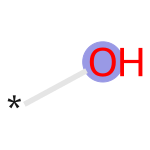

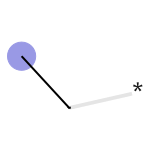

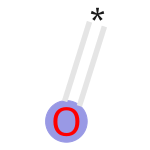

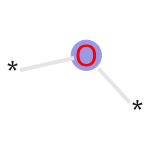

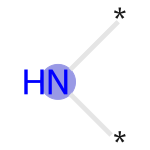

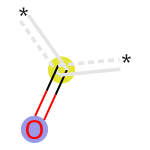

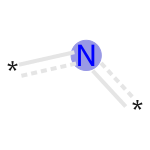

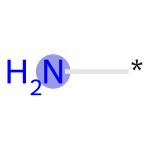

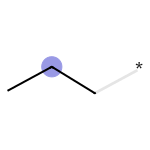

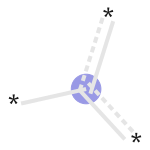

In [33]:
from IPython.display import SVG
import os

dir = "../plots/bits/XGB/"
svgs = os.listdir(dir)

for svg in svgs:
    display(SVG(filename=dir+svg))

